# SAIL: выучивание эвристик. Выполнили: Пузач, Иванов

## Cтруктуры данных для обучения и вспомогательные функции

Эксперименты проводились при помощи google colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/hs

/content/drive/MyDrive/hs


In [31]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
import math
import random
import pickle
from tqdm.notebook import tqdm
import os
import cv2

%matplotlib inline

EPS = 1e-6

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Классы и функции с пар

In [33]:
class GridState:
    def __init__(self, i, j):
        self.i = i
        self.j = j
    
    def __ne__(self, other):
        return (self.i != other.i) or (self.j != other.j)
    
    def __str__(self):
        return f'{self.i}_{self.j}'
    
    def __repr__(self):
        return str(self)

In [34]:
class Map:

    # Default constructor
    def __init__(self, imagePath=None):
        if imagePath is not None:
            self.cells = np.abs(1 - cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE) // 255)
            self.height, self.width = self.cells.shape
        else:
            self.cells = []
            self.height, self.width = 0, 0
    
    def SetGridCells(self, gridCells):
        self.cells = gridCells

    # Checks cell is on grid.
    def inBounds(self, i, j):
        height, width = self.cells.shape
        return (0 <= j < width) and (0 <= i < height)
    
    # Checks cell is not obstacle.
    def Traversable(self, i, j):
        return not self.cells[i][j]

    # Creates a list of neighbour cells as (i,j) tuples.
    def GetNeighbors(self, state, with_obstacles=False):
        i = state.i
        j = state.j
        # TODO Change the function so that the list includes the diagonal neighbors of the cell.
        # Cutting corners must be prohibited
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [-1, -1], [-1, 1], [1, -1], [1, 1]]
        for d in delta:
            next_i = i + d[0]
            next_j = j + d[1]
            if self.inBounds(next_i, next_j):
                if with_obstacles or (self.Traversable(next_i, next_j) and self.Traversable(i+d[0], j) and self.Traversable(i, j+d[1])):
                    neighbors.append(GridState(next_i, next_j))
        return neighbors

In [35]:
class Node:
    def __init__(self, state, g = math.inf, h = 0, f = None, parent = None, k = 0, depth=0):
        self.state = state
        self.g = g
        self.h = h
        self.k = k
        self.depth = depth
        if f is None:
            self.f = self.g + self.h
        else:
            self.f = f        
        self.parent = parent
    
    def __eq__(self, other):
        return (self.state.i == other.state.i) and (self.state.j == other.state.j)
    
    def __ne__(self, other):
        return (self.state.i != other.state.i) or (self.state.j != other.state.j)
    
    def __str__(self):
        return f'Node(i={self.state.i}, j={self.state.j}, g={self.g}, h={self.h})'
    
    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.f < other.f or (self.f == other.f and self.h < other.h)\
        or ((self.f == other.f) and (self.h == other.h) and (self.k < other.k))

In [36]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened.values():
            draw.rectangle((node.state.j * k, node.state.i * k, (node.state.j + 1) * k - 1, (node.state.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded.values():
            draw.rectangle((node.state.j * k, node.state.i * k, (node.state.j + 1) * k - 1, (node.state.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.state.i, step.state.j)):
                    draw.rectangle((step.state.j * k, step.state.i * k, (step.state.j + 1) * k - 1, (step.state.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.state.j * k, step.state.i * k, (step.state.j + 1) * k - 1, (step.state.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)

    return np.asarray(im)

In [37]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [61]:
from heapq import heapify, heappop, heappush

class Open():
    def __init__(self):
        self.pr_queue = []
        self.dict = {}
        
    def __iter__(self):
        return iter(self.dict.values())

    def __len__(self):
        return len(self.dict)

    def isEmpty(self):
        return len(self.dict) == 0
    
    def AddNode(self, item):
        node = self.dict.get(str(item.state), None)
        if node is None or item.g < node.g:
            self.dict[str(item.state)] = item
            heappush(self.pr_queue, item)
            
    def GetBestNode(self, pop=True):
        bestNode = self.pr_queue[0]
        
        while str(bestNode.state) not in self.dict:
            heappop(self.pr_queue)
            bestNode = self.pr_queue[0]
        
        if pop:
            self.dict.pop(str(bestNode.state))
            heappop(self.pr_queue)
        
        return bestNode


class Closed ():
    def __init__(self):
        self.elements = {}
        
    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)
    
    def values(self):
        return self.elements.values()

    def AddNode(self, item, *args):
        self.elements[str(item.state)] = item
        
    def WasExpanded(self, item):
        return str(item.state) in self.elements
    
    def GetNode(self, item):
        return self.elements.get(str(item.state))
    
    def RemoveNode(self, item):
        self.elements.pop(str(item.state), None)

Эвристики

In [62]:
def ManhattanDistance(state1, state2):
    dx = abs(state1.j - state2.j)
    dy = abs(state1.i - state2.i)
    return abs(dx - dy)


def EuclideanDistance(state1,state2):
    return math.sqrt((state1.i - state2.i) ** 2 + (state1.j - state2.j) ** 2)


def DiagonalDistance(state1, state2):
    c_hv = 1
    c_d = math.sqrt(2)
    
    dy = abs(state1.i - state2.i)
    dx = abs(state1.j - state2.j)
    
    return c_hv * abs(dx-dy) + c_d * min(dx,dy)


def radCost(state1, state2):
    dy = abs(state1.i - state2.i)
    dx = abs(state1.j - state2.j)
    return max(dx, dy)

In [63]:
def AStar(gridMap, startState, goalState, calcCost = EuclideanDistance,
          heuristicFunction = DiagonalDistance, reExpansion=False, weight=1):
    OPEN = Open()
    CLOSED = Closed()
    
    start = Node(startState, 0, 0)
    goal = Node(goalState) if goalState is not None else None
    pathFound = False
    
    OPEN.AddNode(start)
    
    while len(OPEN):
        best_node = OPEN.GetBestNode()
        CLOSED.AddNode(best_node)
        
        if goal is not None and best_node == goal:
            pathFound = True
            goal = best_node
            break
             
        for state in gridMap.GetNeighbors(best_node.state):
            neighbor = Node(state, parent=best_node, k=len(CLOSED))
            neighbor.g = best_node.g + calcCost(best_node.state, neighbor.state)
            if abs(weight) > EPS and goal is not None:
                neighbor.h = heuristicFunction(neighbor.state, goal.state)
                
            neighbor.f = neighbor.g + neighbor.h * weight
            
            node = CLOSED.GetNode(neighbor)
            
            if node is None:
                OPEN.AddNode(neighbor)
    
    return pathFound, goal, CLOSED, OPEN

Определим оракула на основе Дейкстры

In [64]:
class Oracle:
    def __init__(self, map_):
        self.map = map_
        self.q = None
        
    def calculateQ(self, goal):
        startState = goal
        goalState = None
        self.q = AStar(self.map, startState, goalState, weight=0)[2].elements
        
        h, w = self.map.cells.shape
        
        for i in range(h):
            for j in range(w):
                state = GridState(i, j) 
                if str(state) not in self.q:
                    self.q[str(state)] = Node(state, g = EuclideanDistance(GridState(0,0), GridState(h,w))+1)
#         self.q = sorted(self.q.values(), key=lambda item: item.g)

        
    def getQ(self, state):
        if str(state) in self.q:
            return self.q[str(state)].g
        return None
    
    def policy(self, open_):
        isOpen = sorted([node for node in self.q.values() if str(node.state) in open_], 
                        key=lambda node: node.g)
        
        return isOpen[0]

Определим класс нейронной сети, которая является ядром алгоритма. Нейросеть оценивает текущее состояние поиска и выбирает вершину из Open, которая будет раскрыта следующей.

In [65]:
class QNet(nn.Module):
    # двухслойная полносвязная нейронная сеть (17, 100, 50, 1) 
    def __init__(self, input_dim=17, hid_dims=(100, 50), output_dim=1):
        super().__init__()
        self.q = nn.Sequential(
            nn.Linear(input_dim, hid_dims[0]),
            nn.ReLU(),
            nn.Linear(hid_dims[0], hid_dims[1]),
            nn.ReLU(),
            nn.Linear(hid_dims[1], output_dim)
        )
                 
    def forward(self, x):
        return self.q(x)

Для обучения сети используется сгенерированный в ходе работы алгоритма SAIL набор данных. 

In [66]:
class SailDataset(torch.utils.data.Dataset):
    def __init__(self, D):
    # D[0]: список состояний поиска(представлены в виде np.array с shape=(17, ))
    # D[1]: список полезности состояний(оценивается по оракулу) 
        self.X, self.y = D       

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Зададим класс NewOpen для использования в SaIL в качестве Open.

In [67]:
from heapq import heapify, heappop, heappush

class NewOpen():
    def __init__(self):
        self.pr_queue = []
        self.dict = {}
        
    def __iter__(self):
        return iter(self.dict.values())

    def __len__(self):
        return len(self.dict)

    def isEmpty(self):
        return len(self.dict) == 0
    
    def AddNode(self, item, priority):
#         node = self.dict.get(str(item.state), None)
#         if node is None or item.g < node.g:
        self.dict[str(item.state)] = item
        heappush(self.pr_queue, (priority, item))
    
    def PopNode(self, item):
        self.dict.pop(str(item.state))
    
    def GetBestNode(self, pop=True):
        _, bestNode = self.pr_queue[0]
        
        while str(bestNode.state) not in self.dict:
            heappop(self.pr_queue)
            _, bestNode = self.pr_queue[0]
        
        if pop:
            self.dict.pop(str(bestNode.state))
            heappop(self.pr_queue)
        
        return bestNode

In [76]:
class Trainer:
    def __init__(self):
        self.oracle = None
        self.start = GridState(200, 0)    # начальная вершина поиска
        self.goal = GridState(0, 200)     # конечная вершина поиска
        self.map = None                   # текущая карта
        self.agent = QNet().to(device)    # нейросеть для предсказания полезности вершин
        self.D = None
#         self.open = {}

        self.frontier = None
        self.f_o = None
        
        self.closed = {}
        self.invalid = set()
        self.train_dataset = None
        self.optimizer = torch.optim.RMSprop(self.agent.parameters(), lr=0.001)
        # в исходной статье: RMSProp, lr = 0.001, mini-batch size = 64
        
    def sampleMap(self, map_type='all', phase='train'):
        datasetPath = './motion_planning_datasets/'
        
        if map_type == 'all':   # выбираем карту произвольного типа
            idx = np.random.randint(len(os.listdir(datasetPath)))
            el = os.listdir(datasetPath)[idx]
        else: 
            el = map_type       # или заданного
        
        if phase == 'train':
            left = 0            # номера изображений из датасета
            right = 800
        elif phase == 'validation':
            left = 800
            right = 900
        else:
            left = 900
            right = 1000
        
        imagePath = os.path.join(datasetPath, el, phase, 
                                 f'{np.random.randint(left, right)}.png')     
        
        self.map = Map(imagePath)
        self.oracle = Oracle(self.map)
        
    def sampleTargetPoints(self):
        startState = None
        goalState = None
        # генерируем допустимые начальную и конечную вершину
        while startState is None or goalState is None:
            s_i = np.random.randint(self.map.cells.shape[0])
            s_j = np.random.randint(self.map.cells.shape[1])  

            if self.map.Traversable(s_i, s_j):
                startState = GridState(s_i, s_j)

            g_i = np.random.randint(self.map.cells.shape[0])                
            g_j = np.random.randint(self.map.cells.shape[1])     

            if self.map.Traversable(g_i, g_j):
                goalState = GridState(g_i, g_j)

        self.start = startState
        self.goal = goalState
        
        self.oracle.calculateQ(self.goal)
        
        
    def extractFeatures(self, node): 
        features = []
        # cгенерируем набор признаков по данному состоянию поиска
        features.extend([node.state.i, node.state.j])
        features.extend([self.goal.i, self.goal.j])
        features.append(node.g)
        features.append(EuclideanDistance(node.state, self.goal))
        features.append(ManhattanDistance(node.state, self.goal))
        features.append(node.depth)
        
        maxDist = (self.map.cells.shape[0] + 2) ** 2 + (self.map.cells.shape[1] + 2) ** 2
        minDist = [maxDist, None]
        minDistX = [maxDist, None]
        minDistY = [maxDist, None]
        
        # нахождение ближайших препятствий
        for obs_state in self.invalid:
            dist = EuclideanDistance(node.state, obs_state)
            distX = abs(node.state.j - obs_state.j)
            distY = abs(node.state.i - obs_state.i)
            
            if dist < minDist[0]:
                minDist[0] = dist
                minDist[1] = obs_state
                
            if distX < minDistX[0]:
                minDistX[0] = distX
                minDistX[1] = obs_state
                
            if distY < minDistY[0]:
                minDistY[0] = distY
                minDistY[1] = obs_state
                
        features.extend([minDist[0], minDist[1].i, minDist[1].j])
        features.extend([minDistX[0], minDistX[1].i, minDistX[1].j])                    
        features.extend([minDistY[0], minDistY[1].i, minDistY[1].j])
                    
        return np.array(features)
           
    def mixPolicy(self, beta):
        # смешанная стратегия: иногда сами принимаем решения, иногда оракул
        if np.random.random(1) < beta:
            res_node = self.f_o.GetBestNode()
            self.frontier.PopNode(res_node)
            return res_node
        
        res_node = self.frontier.GetBestNode()
        self.f_o.PopNode(res_node)
        return res_node

    def AddOpen(self, node, mode='train'):
        if mode == 'train':   # для 'eval', 'test' не требуется
            oraclePriority = self.oracle.getQ(node.state)
            self.f_o.AddNode(node, oraclePriority)
        agentPriority = self.agent(torch.FloatTensor(self.extractFeatures(node)).to(device)).detach().cpu().item()
        self.frontier.AddNode(node, agentPriority)
        
    def expand(self, node, mode='train'):
        for child in self.map.GetNeighbors(node.state, with_obstacles=True):
            if not self.map.Traversable(child.i, child.j):
                self.invalid.add(child)  
            elif str(child) not in self.closed:
                childNode = Node(child, parent=node, depth=node.depth+1, 
                                 g=node.g+EuclideanDistance(node.state, child))
                self.AddOpen(childNode, mode=mode)
    
    def update(self, D, num_epochs=20):
        self.train_dataset = SailDataset(D)
        train_dataloader = torch.utils.data.DataLoader(self.train_dataset, 
                                                       batch_size=64, 
                                                       shuffle=True)
        to_plot = 0.0
        for epoch in range(num_epochs):
            for x_train, y_train in train_dataloader:
                x_train = x_train.to(device).float()
                y_train = y_train.to(device).float()
                
                preds = self.agent(x_train).squeeze()

                loss = F.mse_loss(preds, y_train)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            to_plot += loss.item()
        
        return to_plot/num_epochs/len(self.train_dataset)

    def load_data(self, data_path):
        with open (data_path, 'rb') as fp:
            self.D = pickle.load(fp)

    def load_pretrained(self, model_path):
        self.agent.load_state_dict(torch.load(model_path, map_location=device))

    def train(self, N, m, k, T, beta0, map_type='all', i_start=0):
        # beta - вероятность идти по оракулу
        D = [[], []] if self.D is None else self.D
        for i in range(i_start, N):
            curr_beta = beta0 ** i
            for j in tqdm(range(m)):
                self.sampleMap(map_type=map_type)
                #self.sampleTargetPoints()
                self.oracle.calculateQ(self.goal)
                self.frontier = NewOpen()
                self.f_o = NewOpen()
                self.closed = dict()
                self.invalid = set()

                # добавим 2 искусств. препятствия
                # 1. клетка выше и правее верхнего правого края
                # 2. клетка ниже и левее нижнего левого края
                self.invalid.add( GridState(self.map.cells.shape[0],
                                            self.map.cells.shape[1]) )
                self.invalid.add( GridState(-1, -1) )

                timesteps = set(np.random.choice(range(T), size=k, replace=False))
                max_t = max(timesteps)
                t = 0
                     
                self.AddOpen(Node(self.start, g=0, depth=1))
                
                while t < T and len(self.frontier) > 0:
                    if t in timesteps:
                        node = self.frontier.pr_queue[np.random.randint(len(self.frontier.pr_queue))][1]
#                         node = random.choice(list(self.open.values()))  # выбираем случ. вершину из open
                        D[0].append(self.extractFeatures(node))
                        D[1].append(self.oracle.getQ(node.state))
                    else: 
                        node = self.mixPolicy(curr_beta)  # продолжаем идти по смешанной стратегии
                    
                    self.expand(node)
                    self.closed[str(node.state)] = node

                    if t > max_t or node.state == self.goal: #t не входит в timesteps или достигли цели
                        break    # нет смысла продолжать работать с этим примером
                    t += 1    
            loss = self.update(D)
            print(loss)
            
            model_path = '/content/drive/MyDrive/hs/'+map_type+str(i+1)+'.pt'
            data_path = '/content/drive/MyDrive/hs/data_'+map_type+str(i+1)
            torch.save(self.agent.state_dict(), model_path)
            with open(data_path, 'wb') as fp:
                pickle.dump(D, fp)

    def one_run(self, imagePath, t_max, mode='eval', draw=False):                
        self.map = Map(imagePath)  
        self.closed = dict()
        self.invalid = set()
        self.invalid.add( GridState(self.map.cells.shape[0],
                                    self.map.cells.shape[1]) )
        self.invalid.add( GridState(-1, -1) )
        self.frontier = NewOpen()
        self.AddOpen(Node(self.start, g=0, depth=1), mode=mode)
        done=False
        for t in range(t_max):
            node = self.frontier.GetBestNode()
            if node.state != self.goal:
                self.expand(node, mode=mode)
                self.closed[str(node.state)] = node
            else:
                done = True
                break
        
        if mode == 'eval':
            return len(self.closed) # для валидации важно только число раскрытий
        
        sail_path = MakePath(node)
        #pathFound, goal, CLOSED, OPEN = 
        o_res = AStar(self.map, self.start, self.goal, weight=1)   # оракул
        o_path = MakePath(o_res[1])          # длина пути по оракулу
        
        if draw:
            img_sail = Draw(self.map, self.start, self.goal, sail_path[0], self.closed, self.frontier.dict)
            img_astar = Draw(self.map, self.start, self.goal, o_path[0], o_res[2], o_res[3].dict)
            
            fig, ax = plt.subplots(dpi=200)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.imshow(np.hstack((img_sail, img_astar)))

        return len(self.closed), len(o_res[2]), sail_path[1], o_path[1], done, o_res[0]
    
    def test(self, map_type, model_path, 
             datasetPath='./motion_planning_datasets/',t_max=20000):
        steps = [0, 0]    # 1-ый SAIL, 2-ой AStar
        avg_len = [0, 0]
        correct = [0, 0]         
        self.agent.load_state_dict(torch.load(model_path, map_location=device))
        for img_num in tqdm(range(900, 1000)):
            imagePath = os.path.join(datasetPath,
                                     map_type,
                                     'test',
                                     f'{img_num}.png') 
            info = self.one_run(imagePath, t_max, mode='test')
            steps[0] += info[0]
            steps[1] += info[1]
            avg_len[0] += info[2]
            avg_len[1] += info[3]
            correct[0] += info[4]
            correct[1] += info[5]
        steps = [i / 100 for i in steps]
        avg_len = [i / 100 for i in avg_len]
        
        return {'SaIL': {'expansions avg': steps[0], 'len avg': avg_len[0], 'correct %': correct[0]},
                'AStar': {'expansions avg': steps[1], 'len avg': avg_len[1], 'correct %': correct[1]}}
                
    def validation(self, 
                   map_type,
                   model_path='/content/drive/MyDrive/hs/models/',
                   datasetPath='./motion_planning_datasets/',
                   k_start=3,
                   max_idx=15,
                   t_max=20000, 
                   plot_flag=True):
        num_expansions = np.zeros(max_idx - k_start)
        for k in range(max_idx - k_start):
            k_path = model_path + map_type+str(k+1)+'.pt'
            self.agent.load_state_dict(torch.load(k_path, map_location=device))
            for img_num in tqdm(range(800, 900)):
                imagePath = os.path.join(datasetPath, 
                                         map_type, 
                                         'validation',
                                         f'{img_num}.png')     
                num_expansions[k] += self.one_run(imagePath, 
                                                  t_max=t_max, 
                                                  mode='eval')
            num_expansions[k] /= 100
        if plot_flag:
            plt.title(map_type)
            plt.xlabel('номер итерации')
            plt.ylabel('среднее количество раскрытий')
            plt.plot(np.arange(k_start + 1, max_idx + 1), num_expansions)
        
        return num_expansions.argmin() + 1 + k_start

## Валидация и тест

In [77]:
sail = Trainer()

### Single bugtrap


Лучшая модель была получена после 11 итерации


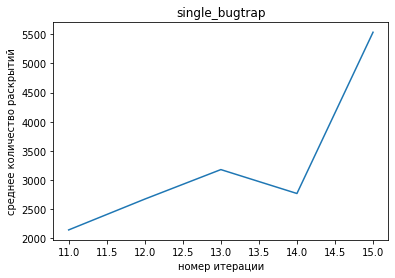

In [29]:
best_on_val = sail.validation(map_type='single_bugtrap', k_start=10, t_max=20000)
print(f'Лучшая модель была получена после {best_on_val} итерации')

In [79]:
sail.test(map_type='single_bugtrap',
          model_path='/content/drive/MyDrive/hs/models/single_bugtrap' + str(best_on_val) + '.pt',
          t_max=20000)

{'AStar': {'correct %': 100,
  'expansions avg': 10754.85,
  'len avg': 306.994687297977},
 'SaIL': {'correct %': 98,
  'expansions avg': 1930.71,
  'len avg': 367.3655393428266}}

(1775, 14052, 357.68838354206923, 317.9898987322343, True, True)

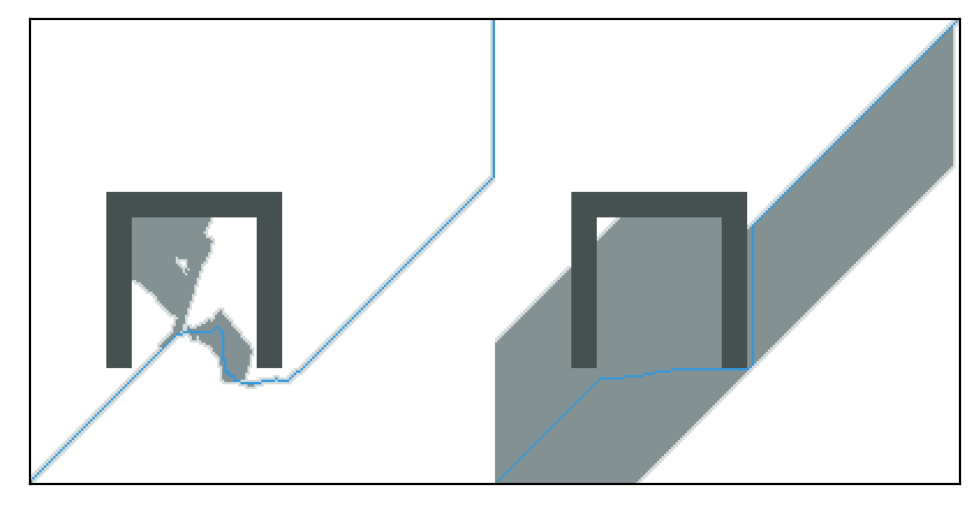

In [85]:
sail.one_run('/content/drive/MyDrive/hs/motion_planning_datasets/single_bugtrap/test/909.png',
             t_max=2000, mode='test', draw=True)
#выход: количество раскрытий SaIL, количество раскрытий AStar, длина пути SaIL,
#       длина пути AStar, SaIL нашел путь, AStar нашел путь

По этому примеру можем видеть, что SaIL ожидает ловушки и начинает её искать в двух направлениях. После того, как наткнулся на две соседние стенки, начинает двигаться в противоположном направлении, выходит из ловушки и жадно движется по диагонали. Заметим, что разница между количеством раскрытий существенна. 

### Alternating gaps

In [ ]:
sail.test(map_type='alternating_gaps',
          model_path='/content/drive/MyDrive/hs/models/alternating_gaps' + str(8) + '.pkl',
          t_max=20000)

{'AStar': {'correct %': 100,
  'expansions avg': 13835.29,
  'len avg': 324.26952934359457},
 'SaIL': {'correct %': 100,
  'expansions avg': 1836.02,
  'len avg': 345.1793972582208}}

(1402, 11907, 325.83051916580007, 313.88939366884574, True, True)

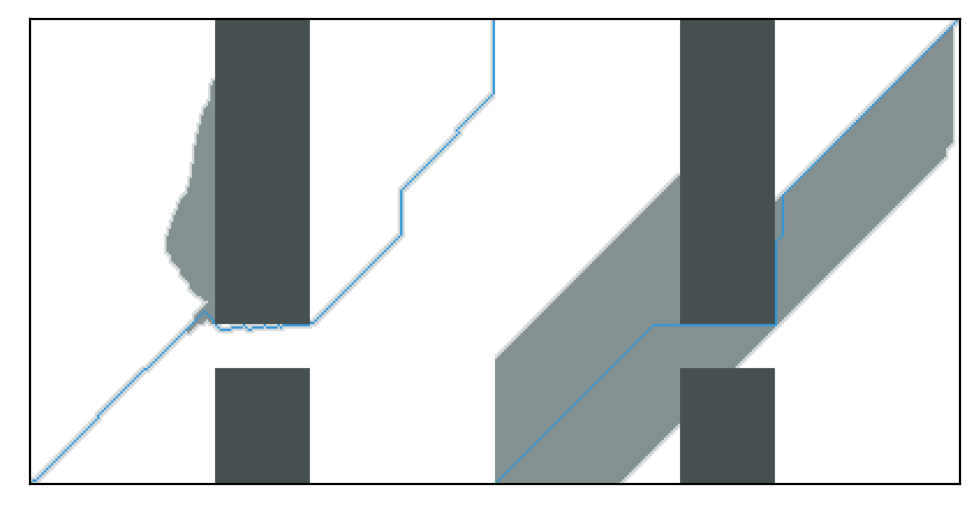

In [ ]:
sail.load_pretrained('/content/drive/MyDrive/hs/models/alternating_gaps8.pkl')
sail.one_run('/content/drive/MyDrive/hs/motion_planning_datasets/alternating_gaps/test/982.png',
             t_max=2000, mode='test', draw=True)
#выход: количество раскрытий SaIL, количество раскрытий AStar, длина пути SaIL,
#       длина пути AStar, SaIL нашел путь, AStar нашел путь

### Bugtrap forest


Лучшая модель была получена после 12 итерации


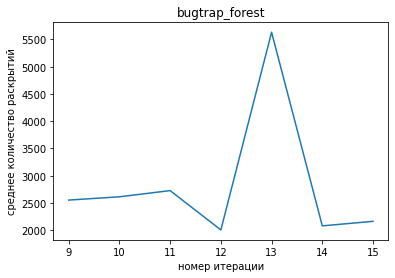

In [ ]:
best_on_val = sail.validation(map_type='bugtrap_forest', k_start=8, t_max=20000)
print(f'Лучшая модель была получена после {best_on_val} итерации')

In [92]:
sail.test(map_type='bugtrap_forest',
          model_path='/content/drive/MyDrive/hs/models/bugtrap_forest' + str(12) + '.pt',
          t_max=20000)

{'AStar': {'correct %': 100,
  'expansions avg': 14950.52,
  'len avg': 326.7766952966377},
 'SaIL': {'correct %': 100,
  'expansions avg': 3797.73,
  'len avg': 767.7982159236922}}

(292, 11438, 344.4751801064726, 315.6467529817262, True, True)

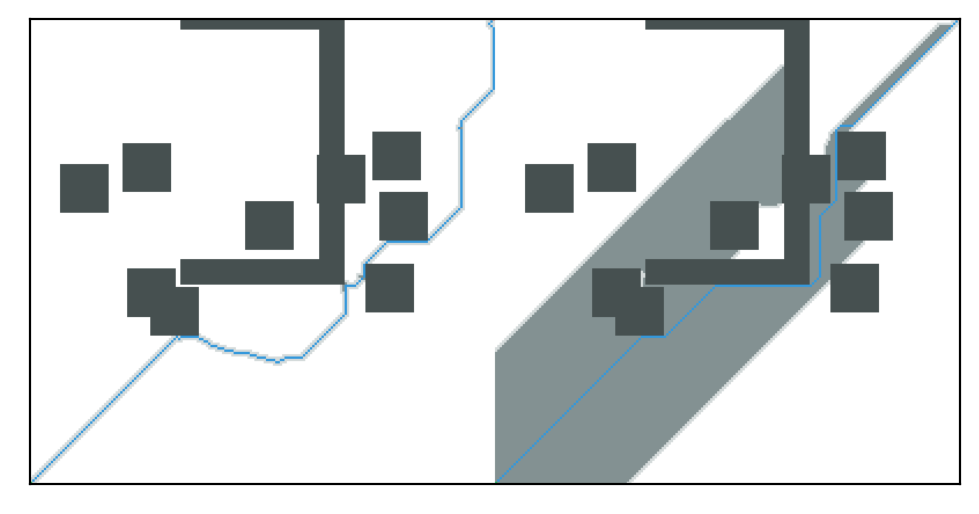

In [93]:
sail.load_pretrained('/content/drive/MyDrive/hs/models/bugtrap_forest12.pt')
sail.one_run('/content/drive/MyDrive/hs/motion_planning_datasets/bugtrap_forest/test/900.png',
             t_max=10000, mode='test', draw=True)
#выход: количество раскрытий SaIL, количество раскрытий AStar, длина пути SaIL,
#       длина пути AStar, SaIL нашел путь, AStar нашел путь

### Multiple bugtraps

In [ ]:
sail.test(map_type='multiple_bugtraps',
          model_path='/content/drive/MyDrive/hs/models/multiple_bugtraps' + str(14) + '.pt',
          t_max=20000)

{'AStar': {'correct %': 100,
  'expansions avg': 15433.76,
  'len avg': 323.334108705232},
 'SaIL': {'correct %': 100,
  'expansions avg': 1876.5,
  'len avg': 425.4390422270816}}

(751, 16350, 410.37467504308427, 326.7766952966374, True, True)

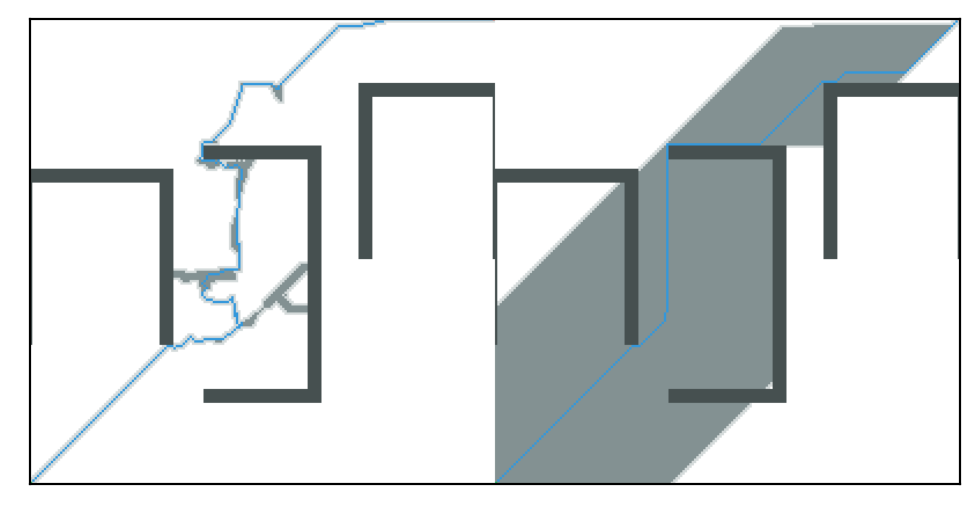

In [ ]:
sail.load_pretrained('/content/drive/MyDrive/hs/models/multiple_bugtraps14.pt')
sail.one_run('/content/drive/MyDrive/hs/motion_planning_datasets/multiple_bugtraps/test/950.png',
             t_max=2000, mode='test', draw=True)
#выход: количество раскрытий SaIL, количество раскрытий AStar, длина пути SaIL,
#       длина пути AStar, SaIL нашел путь, AStar нашел путь

### Forest

In [ ]:
sail.test(map_type='forest',
          model_path='/content/drive/MyDrive/hs/models/forest' + str(10) + '.pkl',
          t_max=20000)

{'AStar': {'correct %': 100,
  'expansions avg': 8254.77,
  'len avg': 306.50262669037073},
 'SaIL': {'correct %': 100,
  'expansions avg': 356.84,
  'len avg': 325.07628109364157}}

(339, 9896, 320.6589462905463, 306.2741699796959, True, True)

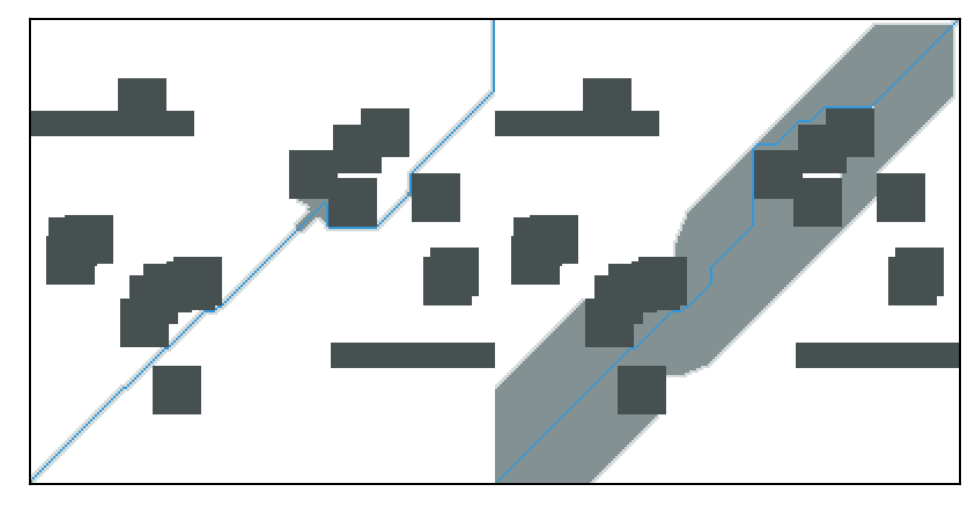

In [ ]:
sail.load_pretrained('/content/drive/MyDrive/hs/models/forest10.pkl')
sail.one_run('/content/drive/MyDrive/hs/motion_planning_datasets/forest/test/970.png',
             t_max=2000, mode='test', draw=True)
#выход: количество раскрытий SaIL, количество раскрытий AStar, длина пути SaIL,
#       длина пути AStar, SaIL нашел путь, AStar нашел путь

## Ячейки с выводом времени обучения и train_loss

На этапе обучения все модели и наборы данных сохранялись в папку, где находился данный jupyter notebook. При прерывании обучения из-за временных ограничений Colab процесс запускался с последней успешной итерации, т.е загружались из данной папки сохраненные модель и датасет. 

Для ясной организации репозитория мы добавили все обученные модели в папку models, поэтому в load_pretrained надо указывать путь

In [ ]:
trainer = Trainer()

In [ ]:
trainer.load_pretrained('single_bugtrap9.pt')

In [ ]:
trainer.train(15, 600, 50, 1100, 0.7, 'single_bugtrap', i_start=9)


0.00806464123803552



0.0036566985882880067



0.002472661768062638



0.0017385064593601937



0.0012962238435802193



0.0010259604060854383


In [ ]:
trainer = Trainer()

In [ ]:
trainer.load_pretrained('multiple_bugtraps4.pt')

In [ ]:
trainer.train(13, 600, 50, 1100, 0.7, 'multiple_bugtraps', i_start=4)


0.011914996719360351



0.006720134143829346



0.004648192227681478



0.004163750476837158


In [ ]:
trainer = Trainer()

In [ ]:
trainer.load_pretrained('multiple_bugtraps7.pt')

In [ ]:
trainer.train(13, 600, 50, 1100, 0.7, 'multiple_bugtraps', i_start=7)


0.01951101791381836



0.010985996805826823



0.007389390644497342



0.007465694465637207



0.004451251495361328



0.0048951471201578774


In [ ]:
trainer = Trainer()

In [ ]:
trainer.train(15, 600, 50, 1100, 0.7, 'bugtrap_forest')


0.0017322362772623698



0.0007978860274950664



0.0009805867841508652



0.0010560959768295289


In [ ]:
trainer = Trainer()

In [ ]:
trainer.load_data('/content/drive/MyDrive/hs/data_bugtrap_forest4')
trainer.load_pretrained('/content/drive/MyDrive/hs/bugtrap_forest4.pt')

In [ ]:
trainer.train(15, 600, 50, 1100, 0.7, 'bugtrap_forest', i_start=4)


0.0017710055173238118



0.0012543367216322158



0.0022108439799717497


In [ ]:
trainer = Trainer()

In [ ]:
trainer.load_data('/content/drive/MyDrive/hs/data_bugtrap_forest7')
trainer.load_pretrained('/content/drive/MyDrive/hs/bugtrap_forest7.pt')

In [ ]:
trainer.train(15, 600, 50, 1100, 0.7, 'bugtrap_forest', i_start=7)


0.0012915529155731202



0.0009432509669551143



0.0010891784044901529



0.0009516285416574188



0.0007414415963490805



0.0009982260151398486



0.001220043325878325



0.0009890671106974284
